In [1]:
import sys
sys.path.append('../')
import numpy as np
import yaml

from resolutions import *
from get_np_arrays import get_kinematics
from get_np_arrays import get_cuts
from unfold import MASK_VAL
import matplotlib.pyplot as plt

2024-03-06 16:12:53.997139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 16:12:53.997808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 16:12:54.083807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 16:12:54.286232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 16:12:57.223201: W tensorflow/compiler/tf2

MASK VAL =  -10


# Lepton - Jet Asymmetry

### $\phi$ is defined as the angle between the total transverse momentum of the system,

### $\vec{q}_\perp = \vec{k}_{\ell\perp} + \vec{k}_{J\perp}$, 

### and the jet relative momentum,

### $\vec{P_\perp} = (\vec{k}_{\ell\perp} - \vec{k}_{J\perp})/2$

### Thus:

### $\cos(\phi) = (\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|$

### and $\phi = \mathrm{acos}[(\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|]$

### Assumption: Perturbative iff $\vec{q}_\perp << \vec{P_\perp}$

### Note: $\hat{t} = (k_l-k)^2 = -Q^2$

https://arxiv.org/pdf/2106.05307.pdf

# Config File and applying MASK

In [2]:
CONFIG_FILE = "../configs/perlmutter_extra_kinematics.yaml"

config = yaml.safe_load(open(CONFIG_FILE))
print(f"\nLoaded {CONFIG_FILE}\n")

mc_type = config['mc']  # Rapgap, Django, Pythia
run_type = config['run_type']  # nominal, bootstrap, systematic
processed_dir = config['main_dir']
NIter = config['n_iterations']
q_perp_bins = config['q_bins']

LABEL = config['identifier']
ID = f"{mc_type}_{run_type}_{LABEL}"

NEVENTS = 100_000


reco_vars = ['e_px', 'e_py', 'e_pz',
               'jet_pt', 'jet_eta', 'jet_phi',
               'jet_dphi', 'jet_qtnorm']

gen_vars = ['gene_px', 'gene_py', 'gene_pz',
              'genjet_pt', 'genjet_eta', 'genjet_phi',
              'genjet_dphi', 'genjet_qtnorm']

theta0_G = np.load(f"../npy_inputs/{ID}_Theta0_G.npy")
theta0_S = np.load(f"../npy_inputs/{ID}_Theta0_S.npy")

#MASK_CUT = np.logical_and(theta0_G[:,0] != MASK_VAL, theta0_S[:,0] != MASK_VAL)
#theta0_G = theta0_G[MASK_CUT]
#theta0_S = theta0_S[MASK_CUT]



Loaded ../configs/perlmutter_extra_kinematics.yaml



In [3]:
# When weights are not applied, these are GEN/TRUTH LEVEL
cuts_h1rpgp       = np.load(f'{processed_dir}/npy_files/{ID}_cuts.npy')
jet_pT_h1rpgp     = np.load(f'{processed_dir}/npy_files/{ID}_jet_pT.npy')
# cuts_h1rpgp = np.ones(len(jet_pT_h1rpgp), dtype=bool)
jet_pT_h1rpgp     = np.load(f'{processed_dir}/npy_files/{ID}_jet_pT.npy')[cuts_h1rpgp]
q_perp_h1rpgp     = np.load(f'{processed_dir}/npy_files/{ID}_q_perp.npy')[cuts_h1rpgp]
asymm_phi_h1rpgp  = np.load(f'{processed_dir}/npy_files/{ID}_asymm_angle.npy')[cuts_h1rpgp]
weights_h1rpgp    = np.load(f'{processed_dir}/npy_files/{ID}_weights.npy')[cuts_h1rpgp]
mc_weights_h1rpgp = np.load(f"{processed_dir}/npy_files/{ID}_mc_weights.npy")[cuts_h1rpgp]
nn_weights_h1rpgp = np.load(f"{processed_dir}/npy_files/{ID}_nn_weights.npy")

ID = ID+"_RECO"
reco_cuts_h1rpgp       = np.load(f'{processed_dir}/npy_files/{ID}_cuts.npy')
reco_jet_pT_h1rpgp     = np.load(f'{processed_dir}/npy_files/{ID}_jet_pT.npy')
# reco_cuts_h1rpgp = np.ones(len(jet_pT_h1rpgp), dtype=bool)
reco_jet_pT_h1rpgp     = np.load(f'{processed_dir}/npy_files/{ID}_jet_pT.npy')[cuts_h1rpgp]
reco_q_perp_h1rpgp     = np.load(f'{processed_dir}/npy_files/{ID}_q_perp.npy')[cuts_h1rpgp]
reco_asymm_phi_h1rpgp  = np.load(f'{processed_dir}/npy_files/{ID}_asymm_angle.npy')[cuts_h1rpgp]
reco_weights_h1rpgp    = np.load(f'{processed_dir}/npy_files/{ID}_weights.npy')[cuts_h1rpgp]
reco_mc_weights_h1rpgp = np.load(f"{processed_dir}/npy_files/{ID}_mc_weights.npy")[cuts_h1rpgp]
reco_nn_weights_h1rpgp = np.load(f"{processed_dir}/npy_files/{ID}_nn_weights.npy")

In [4]:
print(np.shape(theta0_G))
print(np.shape(theta0_S))
print(np.shape(cuts_h1rpgp))
print(np.shape(reco_cuts_h1rpgp))

Reco_Gen_Cuts = np.logical_and(cuts_h1rpgp, reco_cuts_h1rpgp)

(54120770, 12)
(54120770, 12)
(54120770,)
(54120770,)


In [5]:
theta0_G = theta0_G[Reco_Gen_Cuts]
theta0_S = theta0_S[Reco_Gen_Cuts]

In [6]:
print(np.shape(theta0_G))
print(np.shape(theta0_S))
print(np.shape(cuts_h1rpgp))
print(np.shape(reco_cuts_h1rpgp))


(6479476, 12)
(6479476, 12)
(54120770,)
(54120770,)


# Electron and Jet Momentum (Cartesian + Collider)

In [7]:
# ====== Electron =======
reco_e_px = theta0_S[:,0]
reco_e_py = theta0_S[:,1]
reco_e_pz = theta0_S[:,2]
reco_e_pt = np.sqrt(reco_e_px**2 + reco_e_py**2)
reco_e_phi = np.arccos(reco_e_px / reco_e_pt)
reco_e_eta  = np.arcsinh(reco_e_pz / reco_e_pt)

gen_e_px = theta0_G[:,0]
gen_e_py = theta0_G[:,1]
gen_e_pz = theta0_G[:,2]
gen_e_pt = np.sqrt(gen_e_px**2 + gen_e_py**2)
gen_e_phi = np.arccos(gen_e_px/gen_e_pt)
gen_e_eta  = np.arcsinh(gen_e_pz / gen_e_pt)

# ====== Jet =======
reco_jet_pt = theta0_S[:,3]
reco_jet_eta = theta0_S[:,4]
reco_jet_phi  = theta0_S[:,5]
reco_jet_px = np.multiply(reco_jet_pt, np.cos(reco_jet_phi))
reco_jet_py = np.multiply(reco_jet_pt, np.sin(reco_jet_phi))


gen_jet_pt = theta0_G[:,3]
gen_jet_eta = theta0_G[:,4]
gen_jet_phi  = theta0_G[:,5]
gen_jet_px = np.multiply(gen_jet_pt, np.cos(gen_jet_phi))
gen_jet_py = np.multiply(gen_jet_pt, np.sin(gen_jet_phi))

assert(np.shape(gen_jet_pt) == np.shape(reco_jet_pt))

In [8]:
def plot_reco_gen(ax, reco, gen, title="", bins=np.linspace(0,100,101)):
    ax.hist(reco, label="Reco", histtype='step', bins=bins)
    ax.hist(gen, label="Gen", histtype='step', bins=bins, linestyle='--')
    ax.set_title(title)
    ax.legend()

In [9]:
mod_reco_jet_phi = ModPi(reco_jet_phi)
mod_gen_jet_phi = ModPi(gen_jet_phi)

In [10]:
var_strings = ["$p_x^e$", "$p_y^e$", "e_pT", "e_phi", "$p_x^\mathrm{jet}$", "jet_py", "jet_pt", "jet_phi"]
reco_dict = dict(zip(var_strings,[reco_e_px, reco_e_py, reco_e_pt, reco_e_phi, reco_jet_px, reco_jet_py, reco_jet_pt, mod_reco_jet_phi]))
gen_dict = dict(zip(var_strings,[gen_e_px, gen_e_py, gen_e_pt, gen_e_phi, gen_jet_px, gen_jet_py, gen_jet_pt, mod_gen_jet_phi]))
binnings = [np.linspace(-75,75,76), np.linspace(-75,75,76), np.linspace(0,80,41), np.linspace(0,3.2,33)]
binnings = binnings + binnings
assert(reco_dict.keys() == gen_dict.keys())

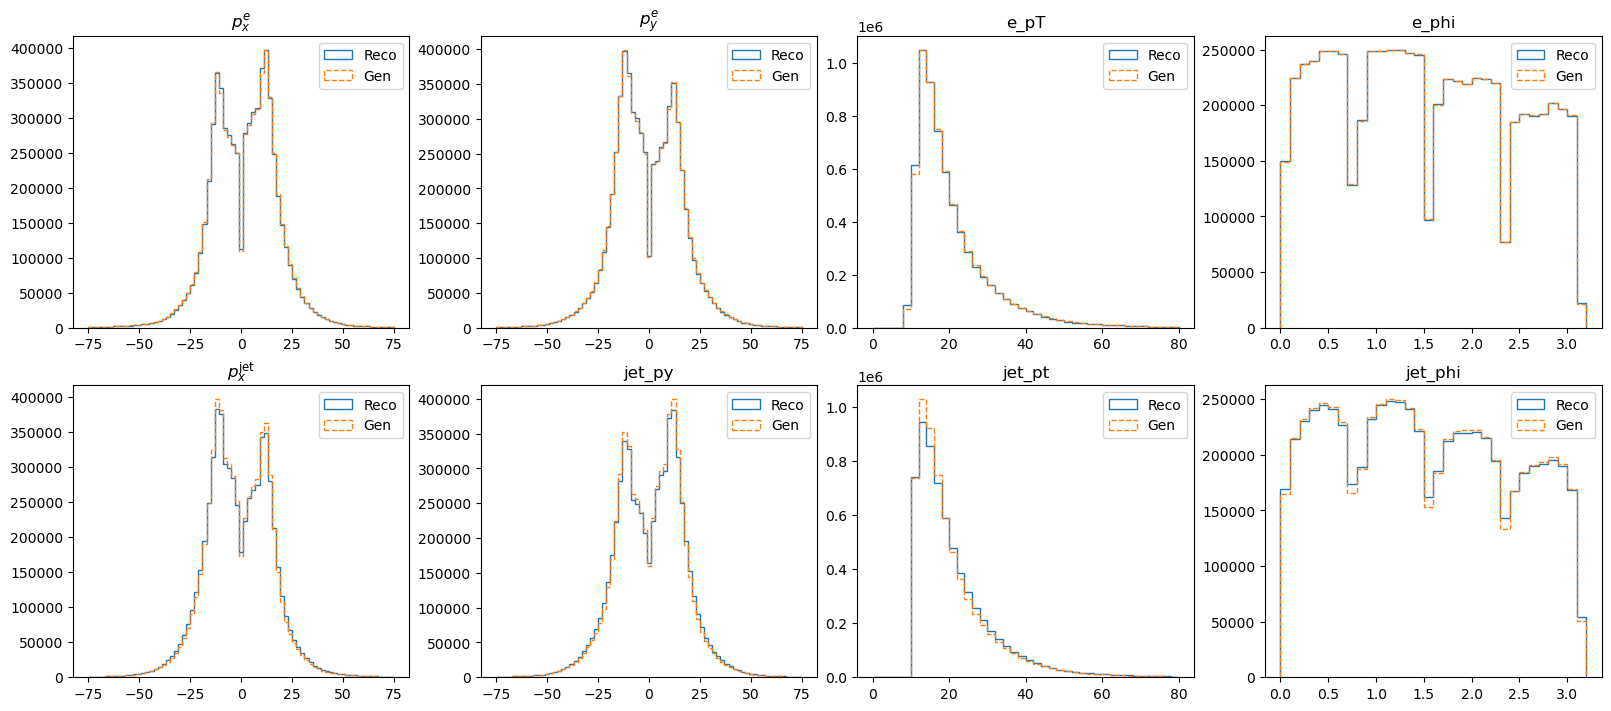

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), constrained_layout=True)
axes = np.ravel(ax)

for ax, key, bins in zip(axes, reco_dict.keys(),binnings):
    plot_reco_gen(ax, reco_dict[key], gen_dict[key], key, bins)
    
plt.savefig("../plots/electron_jet_distributions.pdf")

/pscratch/sd/f/fernando/h1_asymmetry/notebooks/../resolutions.py:44: RuntimeWarning: invalid value encountered in divide
  avg_truth = avg_truth/counter
/global/common/software/nersc9/tensorflow/2.15.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/pscratch/sd/f/fernando/h1_asymmetry/notebooks/../resolutions.py:48: RuntimeWarning: invalid value encountered in divide
  pred_over_truth = pred_over_truth/counter


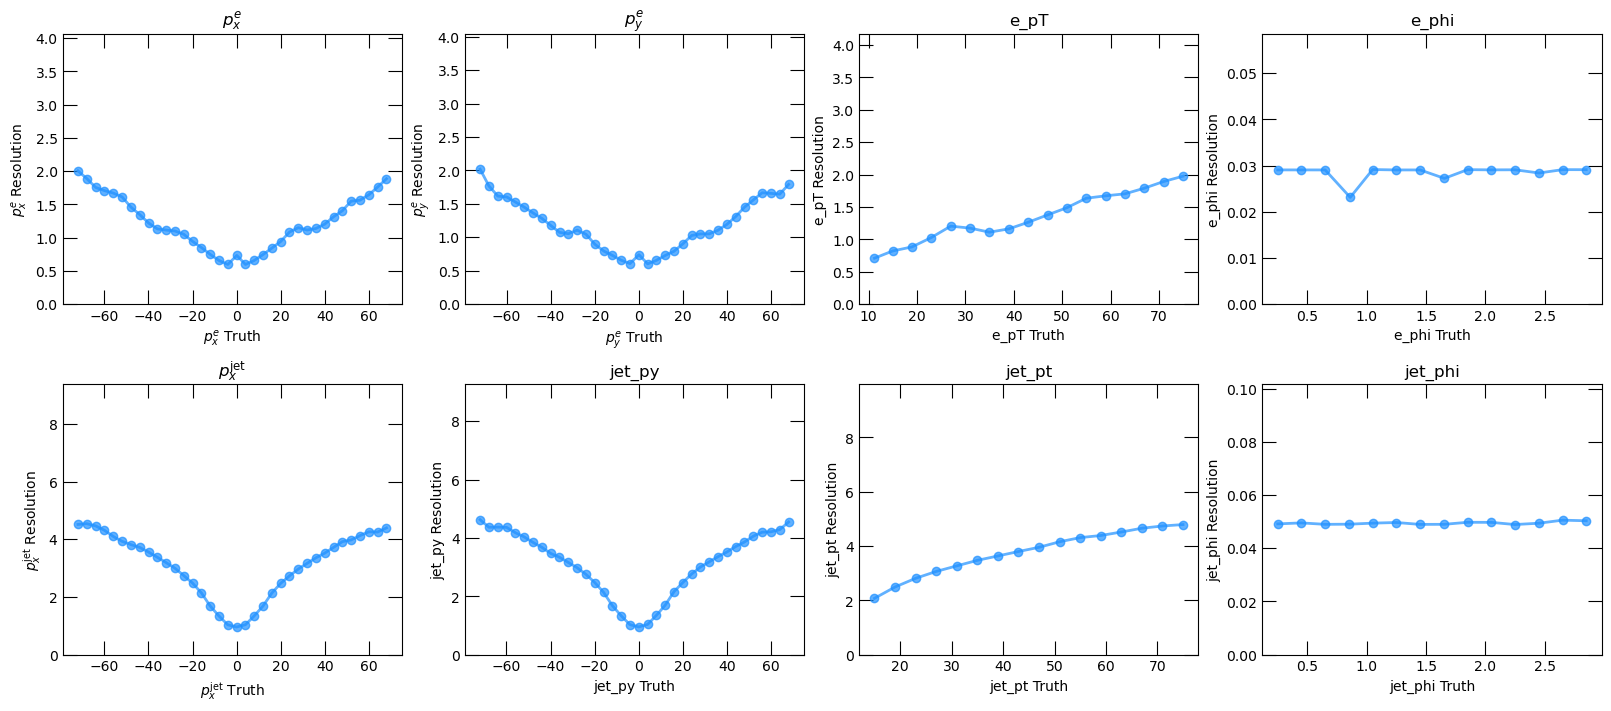

In [12]:
#calculate_resolution(binning, reco, truth)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), constrained_layout=True)
axes = np.ravel(ax)

for ax, key, bins in zip(axes, reco_dict.keys(),binnings):
    avg_gen, res, _, _ = calculate_resolution(bins, reco_dict[key], gen_dict[key])
    avg_gen = avg_gen[~np.isnan(res)]
    res = res[~np.isnan(res)]
    plot_resolution(avg_gen[2:-1:2], res[2:-1:2], title=key, 
                    var=key, ax=ax)
    
plt.savefig("../plots/electron_jet_Resolutions.pdf")

# $\vec{q_\perp}$ and $\vec{P_\perp}$

In [46]:
# =========== RECO =============#
reco_qperp_x = reco_jet_px + reco_e_px
reco_qperp_y = reco_jet_py + reco_e_py

reco_Pperp_x = reco_jet_px - reco_e_px
reco_Pperp_y = reco_jet_py - reco_e_py

reco_qperp_mag = np.sqrt( np.square(reco_qperp_x) + np.square(reco_qperp_y) )
reco_Pperp_mag = np.sqrt( np.square(reco_Pperp_x) + np.square(reco_Pperp_y) )

reco_qperp_angle = np.arccos(reco_qperp_vec[0]/reco_qperp_mag)
reco_Pperp_angle = np.arccos(reco_Pperp_vec[0]/reco_Pperp_mag)

# =========== GEN. =============#

gen_qperp_x = gen_jet_px + gen_e_px
gen_qperp_y = gen_jet_py + gen_e_py

gen_Pperp_x = gen_jet_px - gen_e_px
gen_Pperp_y = gen_jet_py - gen_e_py

gen_qperp_mag = np.sqrt( np.square(gen_qperp_x) + np.square(gen_qperp_y) )
gen_Pperp_mag = np.sqrt( np.square(gen_Pperp_x) + np.square(gen_Pperp_y) )

gen_qperp_angle = np.arccos(gen_qperp_vec[0]/gen_qperp_mag)
gen_Pperp_angle = np.arccos(gen_Pperp_vec[0]/gen_Pperp_mag)

In [47]:
extra_keys = ["$q_x$", "$q_y$", "$q_\perp (\phi)$", "$q_\perp$", "$P_x$", "$P_y$", "$P_\perp (\phi)$", "$P_\perp$"]
extra_reco = dict(zip(extra_keys, [reco_qperp_x, reco_qperp_y, reco_qperp_angle, reco_qperp_mag, reco_Pperp_x, reco_Pperp_y, reco_Pperp_angle, reco_Pperp_mag]))
extra_gen = dict(zip(extra_keys, [gen_qperp_x, gen_qperp_y, gen_qperp_angle, gen_qperp_mag, gen_Pperp_x, gen_Pperp_y, gen_Pperp_angle, gen_Pperp_mag]))
extra_bins = [np.linspace(-25,25,51), np.linspace(-25,25,51), np.linspace(0,3.2,33), np.linspace(0,100,101)]
extra_bins = extra_bins + extra_bins

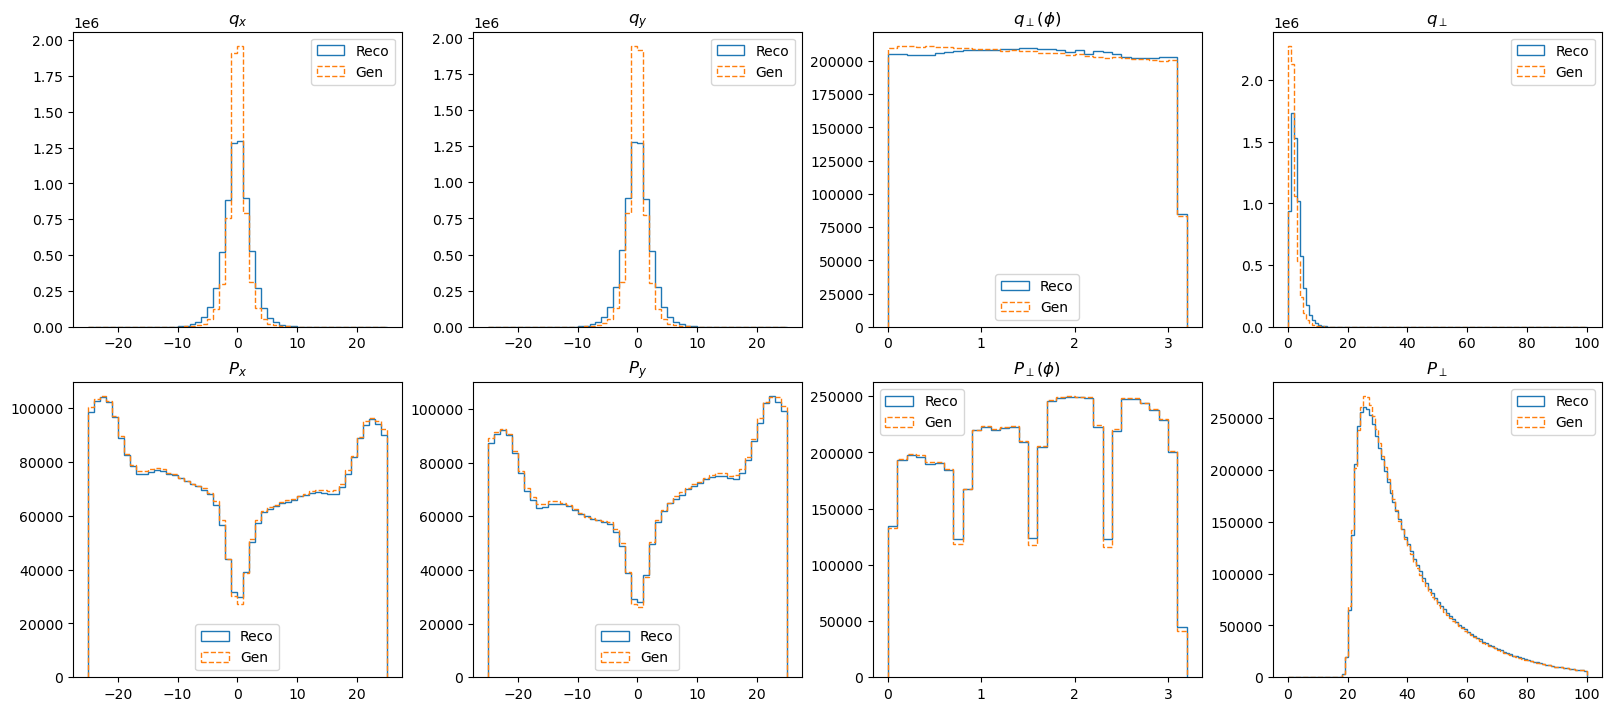

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), constrained_layout=True)
axes = np.ravel(ax)

for ax, key, bins in zip(axes, extra_reco.keys(), extra_bins):
    plot_reco_gen(ax, extra_reco[key], extra_gen[key], key, bins)
    
plt.savefig("../plots/qperp_Pperp_distributions.pdf")

/pscratch/sd/f/fernando/h1_asymmetry/notebooks/../resolutions.py:44: RuntimeWarning: invalid value encountered in divide
  avg_truth = avg_truth/counter
/global/common/software/nersc9/tensorflow/2.15.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/pscratch/sd/f/fernando/h1_asymmetry/notebooks/../resolutions.py:48: RuntimeWarning: invalid value encountered in divide
  pred_over_truth = pred_over_truth/counter


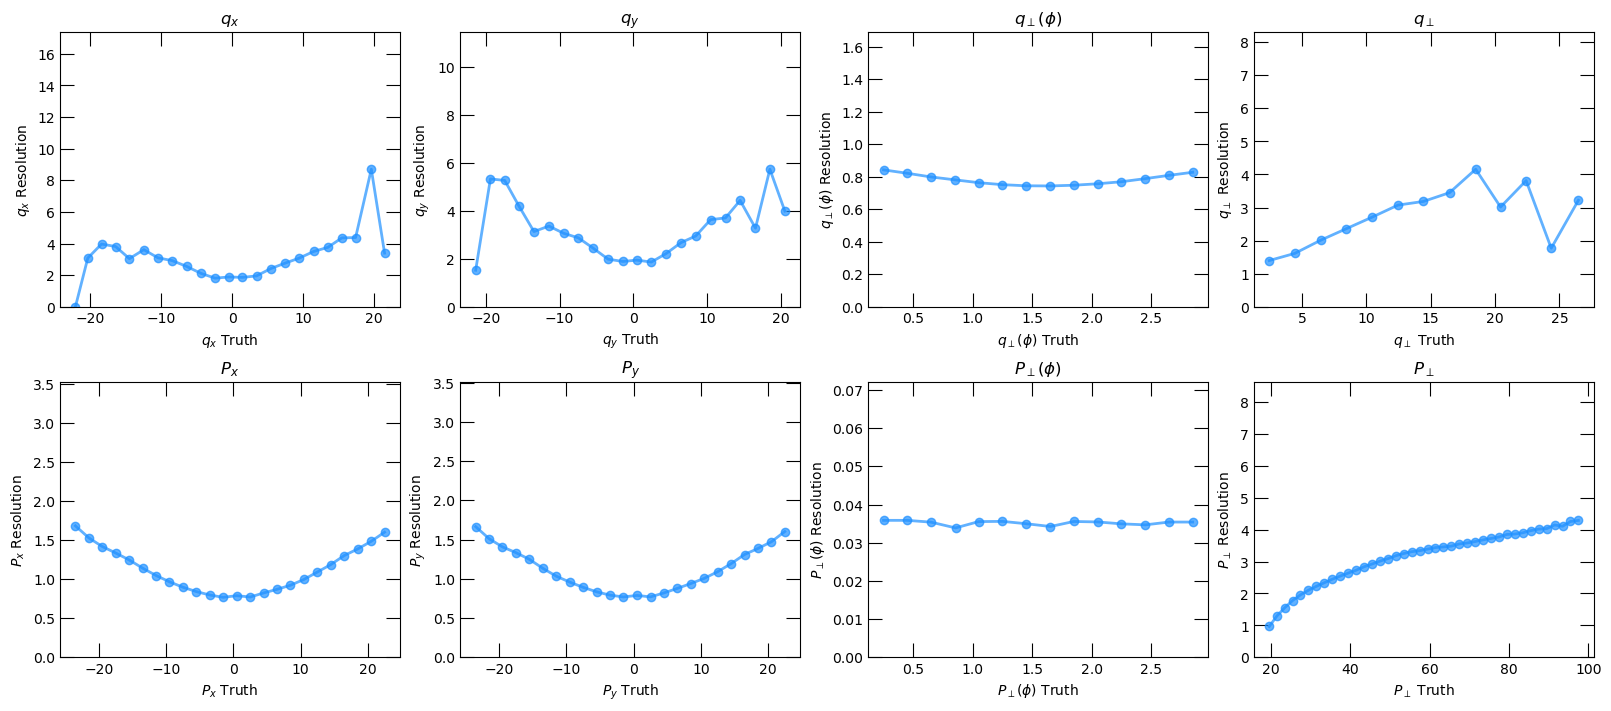

In [49]:
#calculate_resolution(binning, reco, truth)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), constrained_layout=True)
axes = np.ravel(ax)

for ax, key, bins in zip(axes, extra_reco.keys(), extra_bins):
    avg_gen, res, _, _ = calculate_resolution(bins, extra_reco[key], extra_gen[key])
    avg_gen = avg_gen[~np.isnan(res)]
    res = res[~np.isnan(res)]
    plot_resolution(avg_gen[2:-1:2], res[2:-1:2], title=key, 
                    var=key, ax=ax)
    
plt.savefig("../plots/qperp_Pperp_Resolutions.pdf")

# Finally, the asymmetry Angle, taken as the angle between q and P

In [77]:
reco_q_dot_P = reco_qperp_x*reco_Pperp_x + reco_qperp_y*reco_Pperp_y
reco_cosphi = (reco_q_dot_P)/(reco_qperp_mag*reco_Pperp_mag)
reco_asymm_phi = np.arccos(reco_cosphi)

gen_q_dot_P = gen_qperp_x*gen_Pperp_x + gen_qperp_y*gen_Pperp_y
gen_cosphi = (gen_q_dot_P)/(gen_qperp_mag*gen_Pperp_mag)
gen_asymm_phi = np.arccos(gen_cosphi)

phi_binning = np.linspace(0, 3.2, 33)

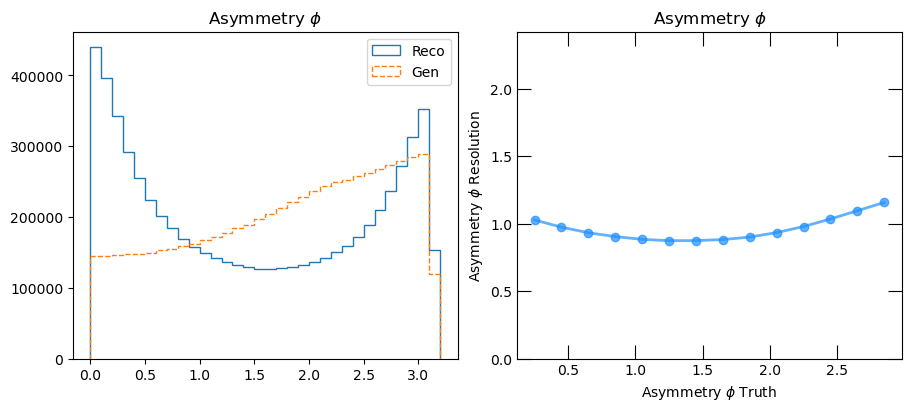

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), constrained_layout=True)
axes = np.ravel(ax)
plot_reco_gen(axes[0], reco_asymm_phi, gen_asymm_phi, "Asymmetry $\phi$", phi_binning)

avg_gen, res, _, _ = calculate_resolution(phi_binning, reco_asymm_phi, gen_asymm_phi)
avg_gen = avg_gen[~np.isnan(res)]
res = res[~np.isnan(res)]
plot_resolution(avg_gen[2:-1:2], res[2:-1:2], title="Asymmetry $\phi$", var="Asymmetry $\phi$", ax=axes[1])

## Old way, don't delete just yet

np.linagle.norm was used after reading this:

https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#rac1c834adb66-1

$\|A\|_F = \sqrt{[\sum_{i,j} |a_{i,j}|^2 ]}$